<a href="https://colab.research.google.com/github/Aiadevop/training_model_wine_quality/blob/main/Notebook_Resumen_DS_NL_Clasificaci%C3%B3n_MODELO_ESCOGIDO_XGBOOST_Predicci%C3%B3n_calidad_del_vino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El proyecto seleccionado es calidad del vino. https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009
El objetivo es darle una puntuación al vino, y a partir de ahí determinar su precio.
En este enlace se muestra como se pueden medir los distintos parámetros del vino y que implica cada uno de ellos: https://cientisol.com/guia-definitiva-sobre-el-analisis-quimico-del-vino-que-parametros-hay-que-medir-y-como-hacerlo/
He comprobado que hay dos modelos de machine learning para este estudio.
Uno que predice la calidad de la uva antes de su recogida permitiendo así variar sus características en las últimas semanas.
Y el segundo es un proyecto académico del vinho verde, la diferencia es que este proyecto clasifica el vino en "MASIVOS" Y "FINOS". Y yo voy a clasificarlo en calidad BAJA/ALTA. https://prezi.com/p/lke8r7ihh8rk/modelos-machine-learning-para-predecir-la-calidad-del-vino/

El dataset que estoy utilizando pertenece a Kaggle y permite su uso, por lo que no necesito de ningún permiso adicional.
El espacio del csv es de 150kB y el colab tiene 70GB por lo que no hay problema de espacio.
A continuación obtengo la información general del dataset y reservo 321 valores para test.

Es un proyecto supervisado ya que los datos ya están etiquetados y dependiendo de sus valores se determina la calidad del vino.
Es un proyecto donde la calidad devuelve una variable numérica pero las clases están muy desbalanceadas ya que nos devolverá un resultado numérico por lo que me decanto por un problema de clasificación:
Por qué: La calidad del vino se mide en niveles discretos definidos por expertos (no una cantidad continua). Por tanto, tiene más sentido modelarla como un problema de clasificación.

Además: Métricas como accuracy, precision, recall y F1-score son más interpretables que errores cuadráticos cuando se trata de predecir niveles de calidad.

Nota: La clase está desbalanceada: la mayoría son 5 y 6. Esto requerirá atención (reagrupamiento, muestreo o uso de pesos en los modelos).

❗ Alternativa: Agrupar calidades Para mejorar la capacidad predictiva y compensar el desbalance, agrupo la variable quality en menos clases. Al estar tan desbalanceadas las clases la clasificación la voy a realizar entre dos valores quality = 0 (entre 3 y 5) y quality = 1 (entre 6 y 8). Si esta clasificación funciona podré probar después a optimizarlo de otra forma.



In [1]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
url="https://raw.githubusercontent.com/Aiadevop/training_model_wine_quality/refs/heads/main/data/df_cl_final.csv"
df_cl = pd.read_csv(url)
# Divido los datos para test y entrenamiento.
from sklearn.model_selection import train_test_split

# Dividir el DataFrame completo. Test_size 20,80 y random_state es la semilla
df_train, df_test = train_test_split(
    df_cl, test_size=0.2, random_state=42, stratify=df_cl['quality']
)

# Luego extraer X e y de cada DataFrame
X_train = df_train.drop('quality', axis=1)
y_train = df_train['quality']

X_test = df_test.drop('quality', axis=1)
y_test = df_test['quality']

In [2]:
# Cargar modelo
import joblib
import requests
import io

# URL RAW del modelo entrenado en GitHub
url_modelo = "https://raw.githubusercontent.com/Aiadevop/training_model_wine_quality/main/models/xgb_model_optimizado.pkl"

# Descargar el archivo y cargar el modelo
response = requests.get(url_modelo)
xgb = joblib.load(io.BytesIO(response.content))

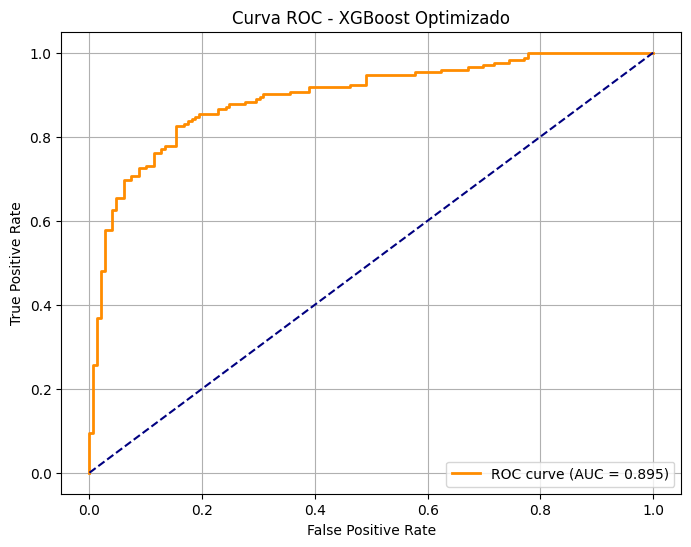

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular probabilidades
y_proba = xgb.predict_proba(X_test)[:, 1]

# Obtener puntos FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost Optimizado')
plt.legend(loc='lower right')
plt.grid()
plt.show()


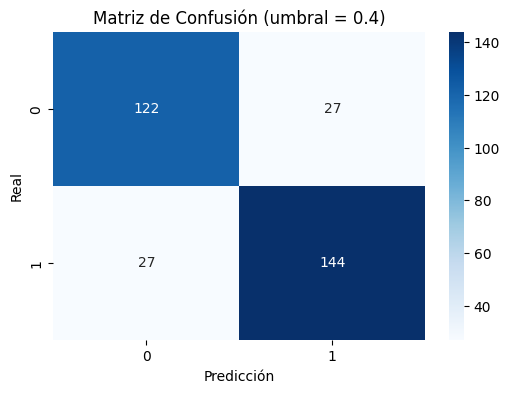

📋 Reporte de clasificación (umbral personalizado):
              precision    recall  f1-score   support

           0      0.819     0.819     0.819       149
           1      0.842     0.842     0.842       171

    accuracy                          0.831       320
   macro avg      0.830     0.830     0.830       320
weighted avg      0.831     0.831     0.831       320



In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Umbral ajustado
threshold = 0.4  # puedes probar con 0.45 o 0.35 también
y_pred_custom = (y_proba >= threshold).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión (umbral = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte detallado
print("📋 Reporte de clasificación (umbral personalizado):")
print(classification_report(y_test, y_pred_custom, digits=3))


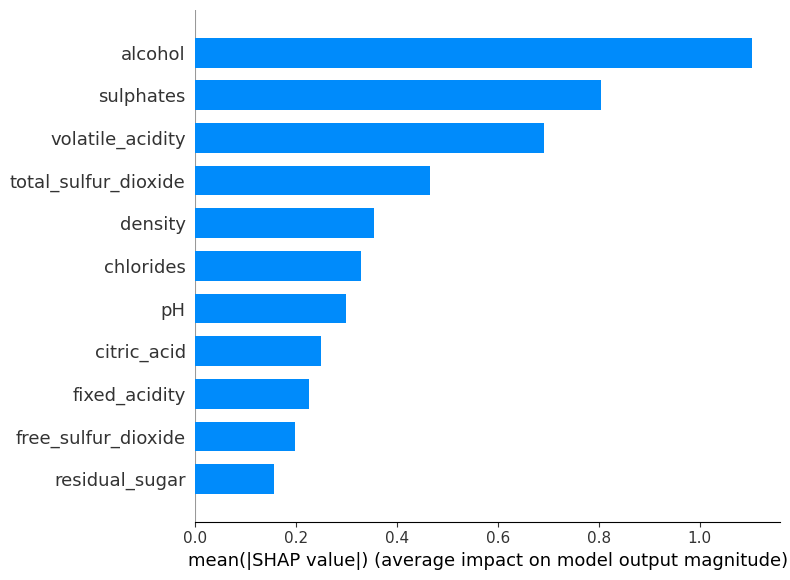

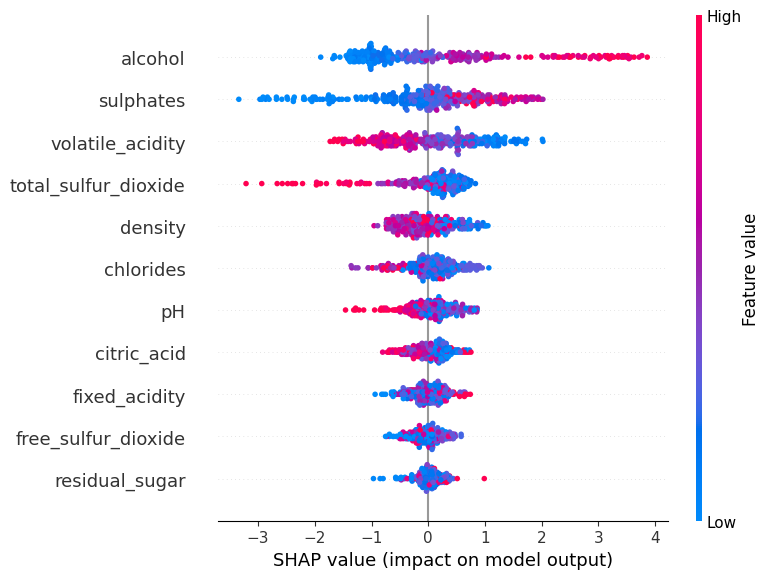

In [5]:
import shap

# Crear explainer con TreeExplainer (específico para XGBoost)
explainer = shap.TreeExplainer(xgb)

# Calcular los valores SHAP para el conjunto de test
shap_values = explainer.shap_values(X_test)

# RESUMEN GLOBAL
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)
